# <center>基于物理信息神经网络的阻尼简谐运动求解</center>

### <center>孙琪, 《应用与计算数学前沿讲座》，2024秋

## 0-1. 物理背景：阻尼谐振子（**damped harmonic oscillator**）

简谐振动是指在线性回复力作用下的质点运动，且在实际应用中往往由于摩擦影响而损失能量，是物理学中一类最重要的运动。

<center><img src="figures//oscillator.gif" width="500">

例如，弹簧的弹性力与其长度变化成正比（胡克定律），是一种线性回复力。记 $u(t)$ 为振子随时间变化的位移，则阻尼运动满足方程
$$
m \dfrac{d^2 u(t)}{d t^2} + \mu \dfrac{d u(t)}{d t} + ku(t) = 0,
$$
其中 $m$ 代表振子质量，$\mu$ 为摩擦系数，$k$ 是弹性系数。我们将重点关注**欠阻尼（under-damped）**情形，即振动随摩擦缓慢衰减（如动画所示）。从数学的角度讲，在系数满足如下关系时会发生欠阻尼现象（[详细推导](https://beltoforion.de/en/harmonic_oscillator/)）
$$
\delta < \omega_0,~~~~~\mathrm{其中阻尼因子}~\delta = \dfrac{\mu}{2m},~~\mathrm{固有角频率}~\omega_0 = \sqrt{\dfrac{k}{m}}.
$$

此外, 我们还需要为系统配备相应的初值条件
$$
u(0) = u_0,~~\dfrac{d u(0)}{d t} = v_0.
$$

在此条件下，方程的解具有解析形式
$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t)),~~~~~\mathrm{其中}~~\omega=\sqrt{\omega_0^2 - \delta^2}
$$
常数 $A$ 和 $\phi$ 由初始条件决定。例如，当 $u_0=1$，$v_0=1$ 时，可得 $\displaystyle \phi = \mathrm{arctan}\left(-\frac{\delta}{\omega}\right)$ 和 $\displaystyle A=\frac{1}{2\cos \phi}$。

## 0-2. 数据驱动 v.s. 物理驱动

给定振子位移 $u(t)$ 在某些时刻的测量值，然后采用神经网络对这些数据进行拟合。

<center><img src="figures//data-driven-approach.gif" width="500"> 

可以观察到，模型对观测数据的**内插预测**表现良好，但却无法完成**外推预测**任务

- <div style="text-align: left">神经网络在较好的拟合数据后，不会再进一步学习物理系统背后的第一性原理，因此导致模型缺乏外推能力。</div>

若在此基础上将物理方程也添加为损失函数，可以有效提升数据驱动方法的外推能力

<center><img src="figures//data-physics-driven-appraoch.gif" width="500"> 

此类方法被统称为物理信息机器学习（Physics-Informed Machine Learning），相关文献可参考 [1998 Lagaris](https://ieeexplore.ieee.org/document/712178)，[2019 Raissi](https://www.sciencedirect.com/science/article/pii/S0021999118307125)，[2021 Karniadakis](https://www.nature.com/articles/s42254-021-00314-5) 和 [2024 Brunton](https://www.nature.com/articles/s43588-024-00643-2)。


## 0-3. 课程目标

学会物理信息神经网络方法（Physics-Informed Neural Networks），并通过 PyTorch 实现阻尼简谐运动的正反问题求解
1. 简谐振子正问题的求解：给定初始条件和模型参数，用 PINNs 对位移变量进行模拟
2. 简谐振子反问题的求解：给定初始条件和位移观测，用 PINNs 对模型参数进行反演
3. 拓展到高频震荡到情形：了解 PINNs 方法的 spectra bias 特性，并改善其收敛速度

## 0-4. 编程环境

通过 conda 命令来设置 Jupyter notebook 的环境变量（查看 Kernel），事先安装必备的 python 库。

```bash
conda create -n workshop python=3
conda activate workshop
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```

In [4]:
import torch
print("torch version =", torch.__version__)
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch version = 2.4.0


### 准备阶段

In [5]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"
    "N_INPUT, N_OUTPUT = Dimension of Input, Output"
    "N_HIDDEN = Width of Hidden Layers"
    "N_LAYERS = Number of Hidden Layers"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x) # 输入层
        x = self.fch(x) # 隐藏层 
        x = self.fce(x) # 输出层
        return x

## 1-1. 任务一: 模拟阻尼简谐振动

- 已知条件：物理方程及其初值条件（欠阻尼情形取 $\delta=2$，$\omega_0=20$）
- 模型输入：时间变量 $t$
- 模型输出：振子位移 $u(t)$，其中 $t\in [0,1]$

#### 函数逼近

得益于人工神经网络的通用逼近性质
- 任意复杂的函数或算子都可以通过一个适当的人工神经网络来表示或逼近

我们使用一个全连接网络（fully-connected neural network）来参数化未知函数，其中神经网络的待定参数用 $\theta$ 表示，即

$$
u_{\mathrm{NN}}(t;\theta) \approx u(t).
$$

#### 损失函数

利用方程的残量作为损失函数，通过求解以下优化问题来近似得到模型的最优参数

$$
\mathcal{L}(\theta)= \frac{1}{N} \sum^{N}_{i=1} \left| \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{NN}}(t_{i};\theta) \right|^2 + \lambda \left( | u_{\mathrm{NN}}(0;\theta) - 1 |^2 + \left|\frac{d\,u_{\mathrm{NN}}}{dt}(0;\theta) - 0\right|^2 \right)
$$

- 第一项为约束方程所对应的损失函数**（physics loss）**，最小化该项可以使得模型解在训练点集 $\{t_i \in(0,1]\}$ 上尽量满足方程；
  
- 后一项为边界条件所对应的损失函数**（boundary loss）**，最小化该项可以使得模型解在 $t=0$ 处尽量满足初值条件 $u(0)=1$ 和 $u'(0)=0$；

其中 $\lambda > 0 $ 为惩罚系数，用于在训练过程中平衡不同损失函数的贡献。这种通过惩罚项来实现边界条件的做法，也被称为软约束**（soft-constraint）**

- 还可以通过构造距离函数、更改输入变量等辅助手段，使模型解严格满足Dirichlet、Neumann 或周期边界条件，称之为硬约束**（hard-constraint）**。

#### 自动微分

自动微分技术**Auto Differentiation**（[`torch.autograd`](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd)）可以用来精确计算模型解关于输入变量的导数，进而用于构造损失函数。

<center><img src="figures//PINNs-flowchart.jpg" width="500"> 

In [ ]:
torch.manual_seed(111) # for reproducibility

# 0-1. problem setting
d, w0 = 2, 20
mu, k = 2*d, w0**2
# 0-2. hyperparameters setting
lmbda = 1/1e-3

# 1. construct a neural network to train
##### TODO: write code here #### u_NN = ???

# 2. generate training and testing sample points
# 2-1. define boundary points, for the boundary loss
##### TODO: write code here #### t_bndry = ???
# 2-2. define interior points over the entire domain, for the physics loss
##### TODO: write code here #### t_intrr = ???
# 2-3. define testing points over the entire domain
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

# 3. training process
optimizer = torch.optim.Adam(u_NN.parameters(), lr= 1e-3)

for i in range(15001):
    optimizer.zero_grad()
    
    # compute each term of the PINN loss function above   
    # boundary loss
    ##### TODO: write code here #### loss_bndry1 = ???  loss_bndry2 = ???
    
    # physics loss
    ##### TODO: write code here #### loss_intrr = ???
    
    # backpropagate joint loss, take optimiser step
    ##### TODO: write code here #### loss = ???
    loss.backward()    
    optimizer.step()
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        # print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = u_NN(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_intrr.detach()[:,0], 
                    torch.zeros_like(t_intrr)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_bndry.detach()[:,0], 
                    torch.zeros_like(t_bndry)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="u_exact", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="u_PINN", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show();

## 1-2. 任务二: 反演阻尼简谐振动的参数

- 模型输入：振子位移的观测值（带噪音）
- 模型输出：阻尼系数 $\mu$

#### 函数逼近

与之前一样，我们使用一个全连接网络（fully-connected neural network）来参数化待求函数，其中神经网络的待定参数用 $\theta$ 表示，即

$$
u_{\mathrm{NN}}(t;\theta) \approx u(t).
$$

不同之处在于，我们还需要将 $\mu$ 看作为一个**待学习的参数**(learnable parameter)。换言之，在求解反问题的过程中，我们会同时模拟位移和反演参数。

#### 损失函数

不同于适定的正问题，反问题所对应的损失函数为

$$
\mathcal{L}(\theta,\mu)= \frac{1}{N} \sum^{N}_{i=1} \left| \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{NN}}(t_{i};\theta) \right|^2 + \frac{\lambda}{M} \sum^{M}_{j=1} \left| u_{\mathrm{NN}}(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right|^2
$$

- 第一项为约束方程所对应的损失函数**（physics loss）**，最小化该项可以使得模型解在训练点集 $\{t_i \in(0,1]\}$ 上尽量满足方程；
  
- 第二项为观测数据所对应的损失函数**（data loss）**，最小化该项可以使得模型解尽可能在观测时刻与测量数据（可能带有噪音）相吻合；

其中 $\lambda > 0 $ 为惩罚系数，用于在训练过程中平衡不同损失函数的贡献。为了叙述简洁，此处缺省了 **boundary loss** 项（对反问题的求解影响不大），也可自行添加。

特别的，通过使用自动微分技术，模型参数 $\theta$ 与 反演参数 $\mu$ 会在优化问题的求解过程中**同步**进行更新。

True value of mu: 4


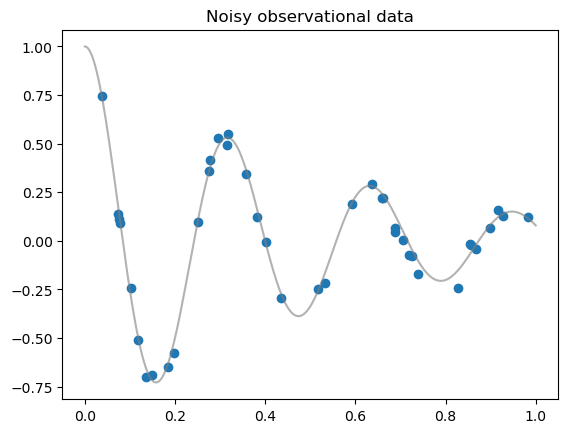

In [6]:
# first, create some noisy observational data
torch.manual_seed(123)
d, w0 = 2, 20
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

In [ ]:
torch.manual_seed(123) # for reproducibility

# 0-1. problem setting
d, w0 = 2, 20
_, k = 2*d, w0**2
# 0-2. hyperparameters setting
lmbda = 1e4

# 1. construct a neural network to train
##### TODO: write code here #### u_NN = ???

# 2. generate training and testing sample points
# 2-1. define interior points over the entire domain, for the physics loss
##### TODO: write code here ####  t_phys = ???
# 2-2. define testing points over the entire domain
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

# 3. training process
# 3-1. treat mu as a learnable parameter
##### TODO: write code here ####  mu = ???
hist_mu = []
# add mu to the optimizer
##### TODO: write code here #### optimizer = ???

# 3-2. network training and parameter learning
for i in range(15001):
    optimizer.zero_grad()
       
    # compute physics loss
    ##### TODO: write code here #### loss_phys = ???
    
    # compute data loss
    ##### TODO: write code here #### loss_data = ???
    
    # backpropagate joint loss, take optimiser step
    ##### TODO: write code here #### loss = ???
    loss.backward()
    optimizer.step()
    
    # record mu value
    hist_mu.append(mu.item())
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        u = u_NN(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], label="u_obs", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="u_PINN", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
        
plt.figure()
plt.title(r"$\mu$")
plt.plot(hist_mu, label=r"$\mu$_PINN")
plt.hlines(2*d, 0, len(hist_mu), label=r"$\mu$_true", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

## 1-3. 任务三: 探索对高频振荡问题的求解效果

>回到任务一，把 $\omega_0$ 的数值从 20 增加到 80，发现物理信息神经网络方法也很难收敛到真解

### 频率偏好

在神经网络的训练过程中，倾向于优先拟合低频分量，再拟合高频分量，也常被称为**（spectra bias）**或者**（frequency principle）**。

函数拟合过程 | 分频逼近过程
- | - 
![alt](figures//F-principle-1.gif) | ![alt](figures//F-principle-2.gif)

#### 解决方案：将先验知识嵌入到模型解

从物理观察或直觉上，我们可以猜测振子的位移是某种正弦函数。据此，我们可以将模型解写为

$$
\hat u_{\mathrm{NN}}(t; \alpha, \beta) = u_{\mathrm{NN}}(t;\theta)  \sin (\alpha t + \beta) \approx u(t),
$$

其中 $\alpha$ 和 $\beta$ 是两个待学习的参数。若将上式与真解进行比较

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))
$$

我们观察到，此时的神经网络 $u_{\mathrm{NN}}(t;\theta)$ 只需负责拟合指数部分，是较为容易做到的。相应的优化问题，需要根据模型解的形式，将约束方程重新整理。

In [ ]:
torch.manual_seed(123) # for reproducibility

# 0-1. problem setting
d, w0 = 2, 80 # note w0 is higher!
mu, k = 2*d, w0**2
# 0-2. hyperparameters setting
lmbda = 1e4

# 1. construct a neural network to train
##### TODO: write code here #### u_NN = ???

# 2. generate training and testing sample points
# 2-1. define interior points over the entire domain, for the physics loss
##### TODO: write code here #### t_intrr = ???
# 2-2. define boundary points, for the boundary loss
##### TODO: write code here #### t_bndry = ???
# 2-3. define testing points over the entire domain
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

# 3. training process
# 3-1. treat alpha, beta as learnable parameters
# define additional a,b learnable parameters in the ansatz
##### TODO: write code here #### a = ???  b = ???
hist_a = []
# add a,b to the optimiser
##### TODO: write code here #### optimizer = ???
# 3-2. network training and parameter learning

for i in range(10001):
    optimizer.zero_grad()
    
    # compute each term of the PINN loss function above    
    # compute boundary loss
    ##### TODO: write code here #### loss_bndry1 = ???  loss_bndry2 = ???
    
    # compute interior loss
    ##### TODO: write code here #### loss_intrr = ???
    
    # backpropagate joint loss, take optimiser step
    ##### TODO: write code here #### loss = ???
    loss.backward()
    optimizer.step()

    # record alpah, beta value
    hist_a.append(a.item())
    
    # plot the result as training progresses
    if i % 2000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = (u_NN(t_test)*torch.sin(a*t_test+b)).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_intrr.detach()[:,0], 
                    torch.zeros_like(t_intrr)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_bndry.detach()[:,0], 
                    torch.zeros_like(t_bndry)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="u_exact", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="u_PINN", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

plt.figure()
plt.title(r"$\alpha$")
plt.plot(hist_a, label=r"$\alpha$_PINN")
plt.hlines(np.sqrt(w0**2-d**2), 0, len(hist_a), label=r"$\alpha$_true", color="tab:green")
plt.legend(loc='lower right')
plt.xlabel("Training step")
plt.show()

## 2. 课后作业（Talk is cheap. Show me the code.）

### 正问题小组作业
- 在正问题的模型训练中，计算迭代解的分频误差，汇报神经网络的频率偏好现象，并尝试进行理论分析。
- 参考资料：[frequency principle](https://arxiv.org/abs/2201.07395)；[spectra bias](https://proceedings.mlr.press/v97/rahaman19a.html)。

### 反问题小组作业1
- 在反问题的模型求解中，除了反演阻尼系数 $\mu$ 以外，同时反演振子质量 $m$ 和弹性系数 $k$，并探索观测噪音对反问题求解精度的影响。
- 参考资料：[iPINN](https://github.com/jmorrow1000/PINN-iPINN/tree/main)。

### 反问题小组作业2
- 假设仅有弹性系数 $k$ 未知，若想要使振子尽快恢复到平衡状态，该如何确定最优的 $k$ 取值，从理论分析和数值模拟两方面进行探索。
- 参考资料：[临界阻尼](https://beltoforion.de/en/harmonic_oscillator/)。

<center><img src="figures//comparison.png" width="300"> 

## 参考资料

1. https://ieeexplore.ieee.org/document/712178

2. www.sciencedirect.com/science/article/pii/S0021999118307125
 
3. https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/